In [1]:
import re
import pandas as pd
from thefuzz import process
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_silver_standard = pd.read_pickle(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\silver_std.pkl')

# Knowledge-Guided Hashing

In [8]:
# ==========================================
# 1. THE MASTER MALAYSIAN DICTIONARY (WITH LOCATION)
# ==========================================
ASPECT_DICT = {
    'FOOD': [
        # Taste & Quality
        'food', 'taste', 'tasty', 'delicious', 'sedap', 'yummy', 'flavor', 'flavour',
        'fresh', 'juicy', 'tender', 'crispy', 'flavorful', 'perfect', 'amazing', 
        'nice', 'bland', 'tasteless', 'hambar', 'burnt', 'raw', 'undercooked', 
        'overcooked', 'soggy', 'stale', 'spoiled', 'terrible', 'awful', 'unappetizing',
        'salty', 'masin', 'sweet', 'manis', 'sour', 'masam', 'spicy', 'pedas', 
        'umami', 'kick', 'wok hei', 'lemak', 'best', 'dishes','herbs', 'spices',
        'chili', 'chewy', 'shiok', 
        
        # Specific Dishes & Items
        'chicken', 'rice', 'nasi', 'mee', 'noodle', 'soup', 'meat', 'seafood', 
        'drink', 'beverage', 'coffee', 'tea', 'dessert', 'cake', 'roti', 'sambal', 
        'kuah', 'goreng', 'nasi lemak', 'char kuey teow', 'roti canai', 'laksa', 
        'satay', 'rendang', 'dim sum', 'wan tan mee', 'hokkien mee', 'chicken rice', 
        'nasi kandar', 'banana leaf', 'tomyam', 'cendol', 'teh tarik', 'kopi', 
        'menu', 'cook', 'chef', 'latte', 'matcha', 'cheese', 'sauce', 'gravy','beef', 
        'mutton', 'sushi','macha', 'kek', 'murtabak', 'cincalok', 
        'kerabu', 'bak kut teh', 'yong tau foo', 'naan', 'otak-otak', 'kuih', 
        'apam', 'chee cheong fun', 'burger', 'biryani', 'ikan', 'ayam', 'watermelon'
        
        # Meal Times 
        'lunch', 'dinner', 'breakfast', 'brunch', 'supper', 'meal', 'eating', 'eat', 
        'makan', 'minum', 'hungry', 'full', 'appetite', 'tapau'
    ],

    'SERVICE': [
        # Speed
        'service', 'slow', 'fast', 'laju', 'lambat', 'quick', 'rapid', 'prompt',
        'efficient', 'delay', 'wait', 'waiting', 'queue', 'tunggu', 'late', 'long', 'lama',
        'minutes'
        
        # Attitude & Staff
        'staff', 'waiter', 'waitress', 'manager', 'boss', 'worker', 'crew',
        'friendly', 'rude', 'polite', 'kasar', 'mesra', 'helpful', 'attentive',
        'welcoming', 'arrogant', 'ignore', 'responsive', 'smiling', 'courteous',
        'knowledgeable', 'clueless', 'serve', 'serving', 'check', 'kantoi', 'slumber'
        'amoi', 'anneh', 'brother', 'abang', 'kakak', 'auntie', 'uncle', 
        'guy', 'lady', 'personnel', 'team', 'cashier'
    ],

    'VALUE': [
        # Price & Worth
        'price', 'cost', 'expensive', 'cheap', 'mahal', 'murah', 'affordable',
        'pricey', 'reasonable', 'worth', 'berbaloi', 'value', 'budget', 'bill',
        'ringgit', 'rm', 'charge', 'tax', 'standard', 'cut throat', 'wallet', 'money',
        'rip-off', 'bargain', 'overpriced',
        
        # Portion Size
        'portion', 'size', 'quantity', 'serving', 'big', 'besar', 'small', 
        'kecil', 'huge', 'tiny', 'generous', 'stingy', 'banyak', 'sikit'
    ],

    'LOCATION': [ 
        # Accessibility & Parking
        'location', 'loc', 'spot', 'area', 'zone', 'position',
        'parking', 'park', 'carpark', 'valet', 'lot','jauh', 'dekat',
        'waze', 'map', 'maps', 'direction', 'find', 'locate', 'accessible',
        'traffic', 'jam', 'station', 'lrt', 'mrt', 'transport', 'strategic'
    ],

    'AMBIENCE': [
        # Interior & Vibes 
        'environment', 'ambience', 'atmosphere',
        'vibe', 'decor', 'decoration', 'interior', 'aesthetic', 'view', 'scenery',
        'comfortable', 'selesa', 'cozy', 'spacious', 'luas', 'sempit', 'cramped',
        'relaxing', 'chill', 'instagram', 'instagrammable', 'music', 'happening',
        'chillax', 
        
        # Comfort & Facilities
        'seat', 'table', 'chair', 'toilet', 'washroom', 'aircon', 
        'air conditioning', 'fan', 'ventilation', 'hot', 'panas', 'cold', 'sejuk', 
        'warm', 'stuffy', 'noise', 'noisy', 'bising', 'loud', 'quiet', 'senyap', 
        'crowd', 'crowded', 'sesak', 'packed', 'busy','space'

         # Cleanliness & Safety
        'clean', 'dirty', 'bersih', 'kotor', 'tidy', 'messy', 'spotless', 
        'filthy', 'hygiene', 'sanitary', 'grimy', 'dusty', 'smell', 'stink',
        
        # Pests & Illness
        'fly', 'flies', 'lalat', 'cockroach', 'lipas', 'roach', 'rat', 'tikus', 
        'insect', 'bug', 'poisoning', 'sick', 'stomach', 'diarrhea', 'vomit', 
        'hair', 'worm'
    ],  
    
    'HALAL COMPLIANCE': [
        'halal', 'muslim', 'syariah', 'zabihah', 'prayer', 'surau', 'solat', 
        'mosque', 'wudhu', 'muslimah', 'jakim', 'bersih', 'suci', 'JAKIM'
    ],

    'NON-HALAL ELEMENTS': [
        'pork', 'lard', 'babi', 'alcohol', 'beer', 'wine', 'liquor', 'stout',
        'draught', 'pint', 'cocktail', 'pub', 'bar', 'char siew', 'siew yoke'
    ],
    
    'AUTHENTICITY & LOCAL VIBE':[
        'authentic', 'traditional', 'asli', 'original', 'local', 'typical', 
        'kampung', 'fusion', 'modern', 'style', 'muhibbah', 'mamak', 'nyonya', 
        'penang', 'ipoh', 'heritage', 'classic'
    ],

    'LOYALTY (RETURN INTENT)': [
        'come', 'coming', 'return', 'visit', 'repeat', 'recommend', 'suggestion', 'recommended'
        'choice', 'option', 'second', 'again', 'definitely','unacceptable',
        'sure', 'always', 'regular', 'back', 'must try', 'disappointed', 'favourite'
    ]
}

# Flatten dictionary for faster lookup
KEYWORD_TO_ASPECT = {word: aspect for aspect, keywords in ASPECT_DICT.items() for word in keywords}

In [9]:
# ==========================================
# 2. DEFINE FUNCTIONS (Segmentation & Mapping)
# ==========================================

def segment_review(text):
    """
    Splits review into clauses using punctuation and conjunctions.
    (Simple Clause Segmentation)
    """
    if pd.isna(text):
        return []
    
    # Split by common delimiters: . , ! ? and 'but'
    # We use regex to keep the delimiters or just split clean
    # Here we split by punctuation or 'but'/'and'
    segments = re.split(r'[.,!?]|\bbut\b|\band\b', str(text).lower())
    
    # Clean up whitespace and ignore empty segments
    return [seg.strip() for seg in segments if len(seg.strip()) > 3]

def identify_aspects(segment):
    """
    Maps a text segment to aspects based on the Dictionary.
    Returns a list of unique aspects found in the segment.
    """
    found_aspects = set()
    words = segment.split()
    
    for word in words:
        # Check direct match
        if word in KEYWORD_TO_ASPECT:
            found_aspects.add(KEYWORD_TO_ASPECT[word])
    
    # If no aspect found, label as "GENERAL" 
    if not found_aspects:
        return ['GENERAL']
    
    return list(found_aspects)


In [10]:
# ==========================================
# 3. APPLY TO DATASET
# ==========================================
print("Running Aspect Extraction...")

results = []

for index, row in df_silver_standard.iterrows():
    # 1. Get Sentiment Label from the original review
    sentiment_label = row['weak_label']
    
    # 2. Segment the text
    segments = segment_review(row['text'])
    
    for seg in segments:
        # 3. Identify Aspect
        aspects = identify_aspects(seg)
        
        for aspect in aspects:
            results.append({
                'Original_Review_ID': index,
                'Full_Review': row['text'],
                'Segment': seg,
                'Aspect': aspect,
                'Sentiment_Label': sentiment_label # Inherit label for now
            })

# Convert to DataFrame
df_aspects = pd.DataFrame(results)

# Filter out 'GENERAL' 
df_aspects_clean = df_aspects[df_aspects['Aspect'] != 'GENERAL']

print("\n PHASE 2 COMPLETE!")
print(f"Original Reviews {len(df_silver_standard):,}")
print(f"Extracted Aspect Segments: {len(df_aspects_clean):,}")
print("\nTop Aspects Found:")
print(df_aspects_clean['Aspect'].value_counts())


Running Aspect Extraction...

 PHASE 2 COMPLETE!
Original Reviews 16,626
Extracted Aspect Segments: 130,762

Top Aspects Found:
Aspect
FOOD                         63856
SERVICE                      16484
AMBIENCE                     13483
VALUE                        12446
LOYALTY (RETURN INTENT)      12000
LOCATION                      5656
AUTHENTICITY & LOCAL VIBE     4376
NON-HALAL ELEMENTS            2040
HALAL COMPLIANCE               421
Name: count, dtype: int64


In [11]:
# Show a sample
print("\nSample Data:")
df_aspects_clean[['Aspect', 'Segment', 'Sentiment_Label']].sample(10)


Sample Data:


,Aspect,Segment,Sentiment_Label
153639,AMBIENCE,i loved their hot chocolate the most,positive
55988,VALUE,overall a good place for a good value meals,positive
199442,SERVICE,the qr code to make your order was presented l...,positive
180823,FOOD,creamy gravy for pasta salami to watery\n2,positive
59269,VALUE,price was very reasonable,positive
168292,FOOD,pls pls to ask for more sambal cili if u are o...,positive
61740,AMBIENCE,the atmosphere immediately changes,positive
57882,AUTHENTICITY & LOCAL VIBE,great place to enjoy authentic southern indian...,positive
135836,LOYALTY (RETURN INTENT),will visit again,positive
78668,FOOD,it’s that good-not salty at all,positive


# Check Aspect Based Dictionary Coverage

In [ ]:
# Calculate Coverage
total_segments = len(df_aspects)
mapped_segments = len(df_aspects[df_aspects['Aspect'] != 'GENERAL'])
coverage_rate = (mapped_segments / total_segments) * 100

print(f"DICTIONARY COVERAGE REPORT")
print(f"Total Segments Extracted: {total_segments:,}")
print(f"Successfully Categorized: {mapped_segments:,}")
print(f"Unmapped (GENERAL): {total_segments - mapped_segments:,}")
print(f"Coverage Rate: {coverage_rate:.1f}%")

# What did we miss? (Analyze the 'GENERAL' bucket)
# Get all text from segments that failed to match anything
unmapped_text = df_aspects[df_aspects['Aspect'] == 'GENERAL']['Segment'].str.cat(sep=' ')

# Count the most frequent words in the unmapped pile
words = unmapped_text.split()
# Filter out short words (stopwords) to see real content
clean_words = [w for w in words if len(w) > 3] 

common_missed = Counter(clean_words).most_common(20)

print("\nTOP 20 MISSED WORDS (Candidates for your Dictionary):")
for word, count in common_missed:
    print(f"- {word}: {count}")

DICTIONARY COVERAGE REPORT
Total Segments Extracted: 208,198
Successfully Categorized: 130,762
Unmapped (GENERAL): 77,436
Coverage Rate: 62.8%

TOP 20 MISSED WORDS (Candidates for your Dictionary):
- with: 3550
- good: 3185
- this: 3008
- place: 2103
- here: 2000
- that: 1996
- experience: 1971
- were: 1966
- they: 1884
- restaurant: 1833
- very: 1644
- overall: 1492
- just: 1363
- have: 1316
- from: 1309
- time: 1305
- their: 1293
- great: 1292
- also: 1247
- there: 1190


# Fuzzy string matching

In [9]:
# Get a clean list of unique keywords
unique_keywords = [k for k in KEYWORD_TO_ASPECT.keys() if len(k) > 3]

In [10]:
def identify_aspects_fuzzy(segment):
    """
    Maps a text segment to aspects using Exact Match AND Fuzzy Match.
    Includes 'Emoji Protection' to stop warnings.
    """
    found_aspects = set()
    words = segment.split()
    
    for word in words:
        # CLEANUP: Remove punctuation
        clean_word = word.strip(".,!?").lower()
        
        if len(clean_word) < 3:
            continue

        # Skip emoji    
        # If the word has no letters (a-z), it is likely an emoji or number. Skip it.
        if not re.search('[a-zA-Z]', clean_word):
            continue

        # --- PASS 1: EXACT MATCH (Fast) ---
        if clean_word in KEYWORD_TO_ASPECT:
            found_aspects.add(KEYWORD_TO_ASPECT[clean_word])
            continue 
            
        # --- PASS 2: FUZZY MATCH (Slower) ---
        if len(clean_word) > 4:
            # Now safe to run because we know it has letters!
            match, score = process.extractOne(clean_word, unique_keywords)
            
            if score >= 85: 
                found_aspects.add(KEYWORD_TO_ASPECT[match])

    if not found_aspects:
        return ['GENERAL']
    
    return list(found_aspects)

In [11]:
print("Running Aspect Extraction with Fuzzy Matching...")

results = []

for index, row in df_silver_standard.iterrows():
    sentiment_label = row['weak_label']
    segments = segment_review(row['text'])
    
    for seg in segments:
        # USE THE NEW FUZZY FUNCTION HERE
        aspects = identify_aspects_fuzzy(seg)
        
        for aspect in aspects:
            results.append({
                'Original_Review_ID': index,
                'Full_Review': row['text'],
                'Segment': seg,
                'Aspect': aspect,
                'Sentiment_Label': sentiment_label
            })

df_aspects = pd.DataFrame(results)
df_aspects_clean = df_aspects[df_aspects['Aspect'] != 'GENERAL']

print("Fuzzy Extraction Complete!")

Running Aspect Extraction with Fuzzy Matching...
Fuzzy Extraction Complete!


In [12]:
# Calculate Coverage
total_segments = len(df_aspects)
mapped_segments = len(df_aspects_clean[df_aspects_clean['Aspect'] != 'GENERAL'])
coverage_rate = (mapped_segments / total_segments) * 100

print(f"DICTIONARY COVERAGE REPORT")
print(f"Total Segments Extracted: {total_segments:,}")
print(f"Successfully Categorized: {mapped_segments:,}")
print(f"Unmapped (GENERAL): {total_segments - mapped_segments:,}")
print(f"Coverage Rate: {coverage_rate:.1f}%")

DICTIONARY COVERAGE REPORT
Total Segments Extracted: 225,907
Successfully Categorized: 170,845
Unmapped (GENERAL): 55,062
Coverage Rate: 75.6%


In [19]:
#  Group by the review ID and Segment Text
# We aggregate the 'predicted_aspect_category' into a list (and use set to remove exact duplicates)
df_aspects_fixed = df_aspects_clean.groupby(['Original_Review_ID', 'Full_Review', 'Segment', 'Sentiment_Label'])['Aspect'].apply(
    lambda x: list(set(x))
).reset_index()

# Rename the column to be clear
df_aspects_fixed.rename(columns={'Aspect': 'Aspect_Labels'}, inplace=True)

# Check the result
print(f"Original Rows: {len(df_aspects_clean)}")
print(f"Fixed Unique Rows: {len(df_aspects_fixed)}")
print("\nSample of Multi-Label Row:")
df_aspects_fixed[df_aspects_fixed['Aspect_Labels'].map(len) > 1].head(1)

Original Rows: 170845
Fixed Unique Rows: 132637

Sample of Multi-Label Row:


,Original_Review_ID,Full_Review,Segment,Sentiment_Label,Aspect_Labels
0,445,Aaliya Famansara serves some of the best crab ...,a must-visit for true malaysian comfort food,positive,"[FOOD, AMBIENCE, LOYALTY (RETURN INTENT)]"


In [20]:
df_aspects_fixed.to_csv(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization.csv')
df_aspects_fixed.to_pickle(r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\aspect_categorization.pkl')

# Distribution of topics in Malaysia Restaurant Reviews

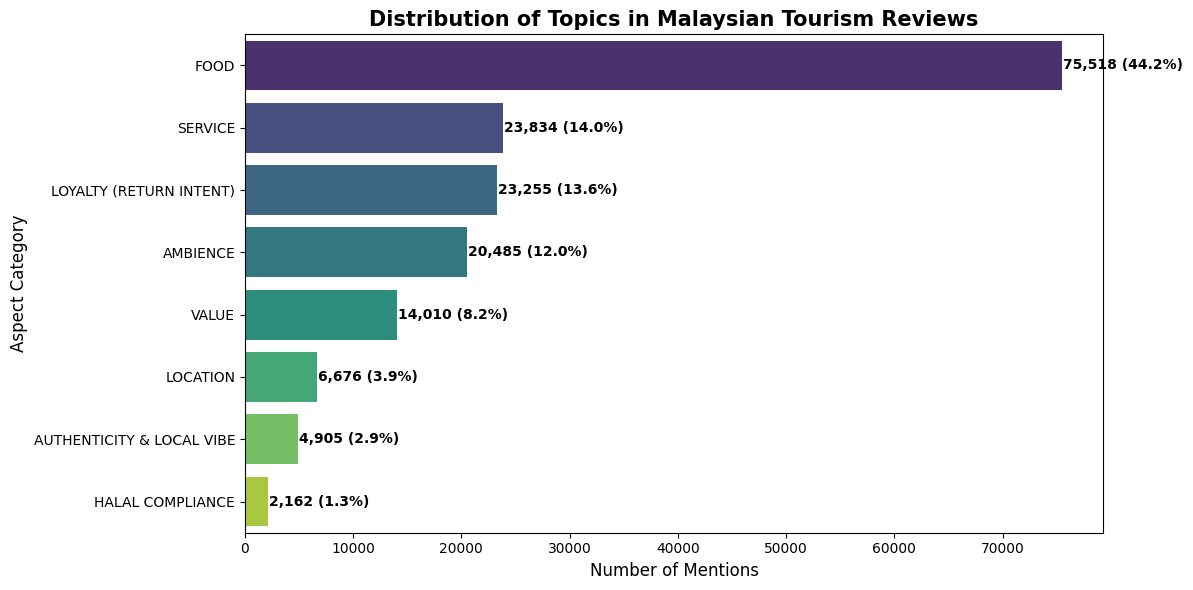

In [15]:
# 1. Prepare Data (Remove General)
plot_data = df_aspects_clean['Aspect'].value_counts().reset_index()
plot_data.columns = ['Aspect', 'Count']

# 2. Calculate Percentages
total = plot_data['Count'].sum()
plot_data['Percentage'] = (plot_data['Count'] / total) * 100

# 3. Create Visualization
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=plot_data, x='Count', y='Aspect', palette='viridis', hue='Aspect', legend=False)

# 4. Add Labels
plt.title('Distribution of Topics in Malaysian Tourism Reviews', fontsize=15, fontweight='bold')
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('Aspect Category', fontsize=12)

# Add percentage text to the bars
for i, v in enumerate(plot_data['Count']):
    pct = plot_data['Percentage'][i]
    ax.text(v + 100, i, f'{v:,} ({pct:.1f}%)', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Preparing for gold standard data

In [24]:
# ==============================================================================
# STRATIFIED SAMPLING (250 POS / 250 NEG)
# ==============================================================================
# Filter by weak label
df_pos = df_silver_standard[df_silver_standard['weak_label'] == 'positive']
df_neg = df_silver_standard[df_silver_standard['weak_label'] == 'negative']

# Random sample 250 from each (Review Level)
sample_pos = df_pos.sample(n=250, random_state=42)
sample_neg = df_neg.sample(n=250, random_state=42)

# Combine to create the list of 500 ID's
gold_review_sample = pd.concat([sample_pos, sample_neg])
gold_ids = gold_review_sample.index 

print(f"Gold Sample Selected: {len(gold_review_sample)} reviews")
print(f"Breakdown: {gold_review_sample['weak_label'].value_counts()}")

# ==============================================================================
# RETRIEVE SEGMENTS & PREPARE EXCEL
# ==============================================================================
# Filter the aspect/segment dataset to only include rows belonging to our 500 reviews
df_gold_segments = df_aspects_fixed[df_aspects_fixed['Original_Review_ID'].isin(gold_ids)].copy()

# Select only necessary columns for the labeler
# Adjust column names based on your actual df_aspects_clean columns
cols_to_export = ['Original_Review_ID', 'Full_Review', 'Segment', 'Aspect_Labels'] 

df_labeling_task = df_gold_segments[cols_to_export].copy()

# Add empty columns for your manual input
df_labeling_task['Manual_Aspect'] = "" 
df_labeling_task['Manual_Sentiment'] = "" 
df_labeling_task['Is_Wrong_segment'] = "" # Checkbox if segmentation was bad

# Export
output_path = r'C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\Gold_Standard_Labeling_Task.xlsx'
df_labeling_task.to_excel(output_path, index=False)

print(f"\nTask Created!")
print(f"Total Segments to Label: {len(df_labeling_task)}")
print(f"File saved to: {output_path}")

Gold Sample Selected: 500 reviews
Breakdown: weak_label
positive    250
negative    250
Name: count, dtype: int64

Task Created!
Total Segments to Label: 4005
File saved to: C:\Users\Ong Hui Ling\Documents\Github\Aspect-Based-Sentiment-Analysis\Dataset\Gold_Standard_Labeling_Task.xlsx
